## Sähkölinjat

* Apuja koordinaattien ja polygonien visualisointiin http://geojson.io
* OSM-Objektien kaappaamista https://overpass-turbo.eu/
* Tagit https://wiki.openstreetmap.org/wiki/Key:power

### Tavoite
* Isojen linjojen alueet openstreetmap->overpass->kuvamaskit -prosessilla
* B08 korkeuskäyrästä maaston/kasvuston korkeus, outlierit pois luettuna
* Pohjatieto jostain parin vuoden takaisesta kuvasta
* Sektorit alueille => Kuvan pienentäminen tilastollista funktiota hyödyntäen => esim. 4x4 pikselin alue = 40m x 40m alue 
* Numpyn tai scipyn avulla laskenta matriisille maskattuna

`
import MA
a = MA.array([1, 2, None], mask = [0, 0, 1])
MA.average(a)
`
##### Tai 
`
import scipy.stats.stats as st
m=st.nanmean(vec)
`

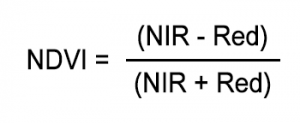

### MXNET Mallit
* Gluon esimerkki 
* Labeleiden formaatti

### Input
* Satelliittikuvasta tiedot
* Kuvan koko pikseleissä 109800 x 109800 (koordinaatit muutettuna UTM vastaa tätä kokoa)
* Query

### Output
* iname,n[|cx,cy,w,h,label]

In [1]:
%config IPCompleter.greedy=True

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry as geometry
from shapely.ops import linemerge, unary_union, polygonize
import utm
import overpy
import time
import cv2
import scipy.sparse
import sys

In [3]:
# Satelliittikuvan alue
points = np.array([
            [
              65.80591820047655, 24.8120825440702
            ],
            [
              65.8214035188828, 27.213549565024742
            ],
            [
              64.8362407624999, 27.20571148892141
            ],
            [
              64.8214388312971, 24.892314281559564 # origo 0,0
            ],
            [
              65.80591820047655, 24.8120825440702
            ]
          ]);

### Rakennukset ja niiden sijainnit Open Street Mapsista
* Overpass API Query


In [4]:
api = overpy.Overpass(url="http://overpass-api.de/api/interpreter")

In [5]:
query = """
[timeout:99999];
(
  node[power=line](64.8214388312971, 24.8120825440702, 65.8214035188828, 27.20571148892141);
  way[power=line](64.8214388312971, 24.8120825440702, 65.8214035188828, 27.20571148892141);
);
out;
"""

In [6]:
response = api.query(query);
lss = [];
print("Ways:", len(response.ways))

Ways: 129


In [7]:
for i, way in enumerate(response.ways):
    print(i, way.tags)
    ls_coords = []
    try:
        nodes = way.get_nodes(resolve_missing=True);
    except:
        time.sleep(60);
        nodes = way.get_nodes(resolve_missing=True);
    finally:
        #does this get executed in try
        for node in nodes:
            ls_coords.append((node.lon,node.lat));
    
    lss.append(ls_coords);

0 {'cables': '3', 'note': 'FIXME verification, details needed', 'power': 'line', 'source': 'landsat; Yahoo; Bing; Gps', 'voltage': '220000'}
1 {'cables': '3', 'power': 'line', 'source': 'Bing', 'voltage': '400000'}
2 {'cables': '3', 'operator': 'Fingrid', 'power': 'line', 'ref': '2530', 'source': 'Mapbox aerial, MML', 'voltage': '110000'}
3 {'cables': '3', 'power': 'line', 'voltage': '400000'}
4 {'cables': '3', 'operator': 'Fingrid Oyj', 'power': 'line', 'source': 'MML, Bing;aerial image', 'source_ref': 'Bing', 'voltage': '400000'}
5 {'cables': '3', 'power': 'line', 'source': 'bing', 'voltage': '400000'}
6 {'power': 'line'}
7 {'power': 'line'}
8 {'power': 'line'}
9 {'cables': '6', 'power': 'line', 'voltage': '110000'}
10 {'power': 'line', 'voltage': '110000'}
11 {'power': 'line'}
12 {'cables': '3', 'power': 'line'}
13 {'cables': '3', 'power': 'line', 'voltage': '220000'}
14 {'cables': '3', 'operator': 'Fingrid', 'power': 'line', 'ref': '1872', 'source': 'Bing, MML', 'voltage': '400000'

### Output tiedostoon

In [14]:
o_x, o_y, _, _ = utm.from_latlon(points[3][0], points[3][1]);

img = np.zeros((10980, 10980, 3), dtype = "uint8");

i = 0;
for ls in lss:
    pts = np.empty((0,2)).astype('int32');
    i += 1;
    for xy in ls:
        x, y, _, _ = utm.from_latlon(float(xy[1]), float(xy[0]));
        x = int(x - o_x);
        y = 109800-int(y - o_y);
        pts = np.append(pts, [int(x/10), int(y/10)]);
    pts = pts.reshape((-1,1,2));
    cv2.polylines(img,[pts],False,(255,255,255), 3);

In [15]:
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
_, img_bw = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY);

In [16]:
sp_mask = scipy.sparse.csc_matrix(img_bw)

In [17]:
scipy.sparse.save_npz('powerline_mask.npz', sp_mask);

In [18]:
cv2.imwrite("powerline_mask.png", img_bw)

True

In [25]:
sys.getsizeof(img)

36168120128

In [26]:
sys.getsizeof(img_bw)

12056040112

In [24]:
sys.getsizeof(sp_mask)

56

In [13]:
o_x

399960.0000006152